### The logistic map
Is defined as $x_{i + 1} = \alpha x_{i}(1 - x_{i})$. For $\alpha = 4$ it maps $[0,1]$ onto itself. For $\alpha = 4$ the invariant density is $$ \pi(dx) := \frac{1}{\pi\sqrt{x(1 - x)}}dx,$$
which is a beta distribution with parameters $a = b = 0.5$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import beta
import sys
sys.path.append("../../")
from DynamicalSystems.koopman_regression import KernelRidgeRegression, ReducedRankRegression, PrincipalComponentRegression
from DynamicalSystems.kernels import Linear, Quadratic, RBF, Matern

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
a, b = 0.5, 0.5
def logistic_map(x, r = 4):
    return r * x * (1 - x)

#### IID samples

In [10]:
kernel = Matern(nu=0.5, length_scale=0.5)
rank = 25
estimators = [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression]
train_max = 1000
train_sizes = np.arange(0, train_max + 1, 20)[1:]

test_size = 100
test_repetitions = 10
test_X = beta.rvs(a, b, size = (test_size, test_repetitions))
test_Y = np.empty_like(test_X)

for i in range(test_repetitions):
    test_Y[:,i] = logistic_map(test_X[:,i])

train_repetitions = 1
errors = np.zeros((len(train_sizes), test_repetitions, len(estimators)))

for i, estimator in enumerate(estimators):
    for j, train_size in tqdm(enumerate(train_sizes), desc = f'{estimator.__name__}', total = len(train_sizes)):
        X = beta.rvs(a, b, size = train_size)[:, None]
        Y = logistic_map(X)
        tikhonov_reg = 0.01*train_size**(-0.5)
        if estimator == KernelRidgeRegression:
            e = estimator(kernel, tikhonov_reg=tikhonov_reg)
        else:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg)
            #e = estimator(kernel, rank)
        e.fit(X, Y, backend='cpu')
        for k in range(test_repetitions):
            errors[j,k,i] = e.risk(test_X[:,k][:, None], test_Y[:,k][:, None])

KernelRidgeRegression: 100%|██████████| 50/50 [00:04<00:00, 10.72it/s]


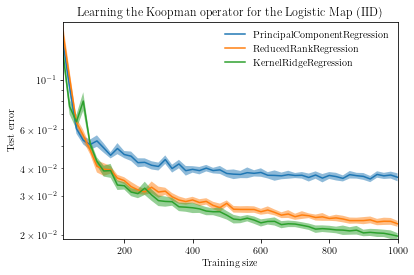

In [11]:
for idx, estimator in enumerate(estimators):
    mean = np.mean(errors[:,:,idx], axis = 1)
    std = np.std(errors[:,:,idx], axis = 1)
    plt.fill_between(train_sizes, mean - std, mean + std, alpha = 0.5)
    plt.plot(train_sizes, mean, '-', label = estimator.__name__)
plt.margins(0)
plt.legend(frameon=False)
plt.ylabel("Test error")
plt.xlabel("Training size")
plt.title("Learning the Koopman operator for the Logistic Map (IID)")
plt.savefig("figs/logistic_map_error.pdf")
plt.yscale('log')

In [5]:
def ds(x0,n, sigma = 0.1):
    x = np.empty(n,dtype=np.float64)
    x[0] = x0
    for t in range(1,n):
        x_ = logistic_map(x[t-1]) + sigma *np.random.randn()
        x[t] = (x_) - int(x_) 
    return x

#### non IID samples

In [6]:
kernel = Matern(nu=0.5, length_scale=0.5)
rank = 25
estimators = [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression]
train_max = 1000
train_sizes = np.arange(0, train_max + 1, 20)[1:]

test_size = 100
test_repetitions = 10
offset = 200
sigma = 0.

test_X = np.random.rand(test_size, test_repetitions)
test_Y = np.empty((test_size, test_repetitions), dtype = np.float64) 

for k in range(test_repetitions):
    test_data = ds(np.random.rand(), test_size+1,  sigma = sigma)
    test_X[:,k] = test_data[:-1]
    test_Y[:,k] = test_data[1:]

train_repetitions = 1

errors = np.zeros((len(train_sizes), test_repetitions, len(estimators)))

for i, estimator in enumerate(estimators):
    for j, train_size in tqdm(enumerate(train_sizes), desc = f'{estimator.__name__}', total = len(train_sizes)):
        data = ds(np.random.rand(), offset + train_size +1,  sigma= sigma)
        X = data[offset:-1][:,None]
        Y = data[offset+1:][:,None]
        tikhonov_reg = 0.01*train_size**(-0.5)
        if estimator == KernelRidgeRegression:
            e = estimator(kernel, tikhonov_reg=tikhonov_reg)
        else:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg)
            #e = estimator(kernel, rank)
        e.fit(X, Y, backend='cpu')
        for k in range(test_repetitions):
            errors[j,k,i] = e.risk(test_X[:,k][:,None], test_Y[:,k][:,None])

KernelRidgeRegression: 100%|██████████| 50/50 [00:04<00:00, 10.49it/s]


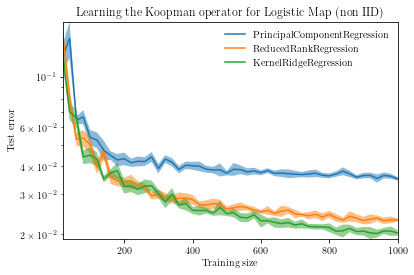

In [7]:
for idx, estimator in enumerate(estimators):
    mean = np.mean(errors[:,:,idx], axis = 1)
    std = np.std(errors[:,:,idx], axis = 1)
    plt.fill_between(train_sizes, mean - std, mean + std, alpha = 0.5)
    plt.plot(train_sizes, mean, '-', label = estimator.__name__)
plt.margins(0)
plt.legend(frameon=False)
plt.ylabel("Test error")
plt.xlabel("Training size")
plt.title("Learning the Koopman operator for Logistic Map (non IID)")
plt.savefig("figs/logistic_map_error.pdf")
plt.yscale('log')

#### non IID samples + noise

In [8]:
kernel = Matern(nu=0.5, length_scale=0.5)
rank = 5
estimators = [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression]
train_max = 1000
train_sizes = np.arange(0, train_max + 1, 20)[1:]

test_size = 100
test_repetitions = 10
offset = 500
sigma = 0.1

test_X = np.random.rand(test_size, test_repetitions)
test_Y = np.empty((test_size, test_repetitions), dtype = np.float64) 

for k in range(test_repetitions):
    test_data = ds(np.random.rand(), test_size+1,  sigma = sigma)
    test_X[:,k] = test_data[:-1]
    test_Y[:,k] = test_data[1:]

train_repetitions = 1

errors = np.zeros((len(train_sizes), test_repetitions, len(estimators)))

for i, estimator in enumerate(estimators):
    for j, train_size in tqdm(enumerate(train_sizes), desc = f'{estimator.__name__}', total = len(train_sizes)):
        data = ds(np.random.rand(), offset + train_size +1,  sigma= sigma)
        X = data[offset:-1][:,None]
        Y = data[offset+1:][:,None]
        tikhonov_reg = 0.01*train_size**(-0.5)
        if estimator == KernelRidgeRegression:
            e = estimator(kernel, tikhonov_reg=tikhonov_reg)
        else:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg)
            #e = estimator(kernel, rank)
        e.fit(X, Y, backend='cpu')
        for k in range(test_repetitions):
            errors[j,k,i] = e.risk(test_X[:,k][:,None], test_Y[:,k][:,None])

KernelRidgeRegression: 100%|██████████| 50/50 [00:06<00:00,  7.89it/s]


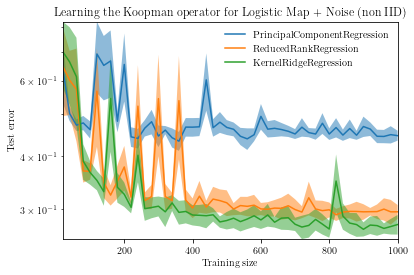

In [9]:
for idx, estimator in enumerate(estimators):
    mean = np.mean(errors[:,:,idx], axis = 1)
    std = np.std(errors[:,:,idx], axis = 1)
    plt.fill_between(train_sizes, mean - std, mean + std, alpha = 0.5)
    plt.plot(train_sizes, mean, '-', label = estimator.__name__)
plt.margins(0)
plt.legend(frameon=False)
plt.ylabel("Test error")
plt.xlabel("Training size")
plt.title("Learning the Koopman operator for Logistic Map + Noise (non IID)")
plt.savefig("figs/logistic_map_error.pdf")
plt.yscale('log')